In [51]:
import pandas as pd
import numpy as np 
import math
import os

### PCA Explanation

*La tecnica del PCA extrae los componentes principales de una matriz, en este caso extraera las componentes principales de la varianza historica de los forward rates.*

Suppose we have $\mathbb{X}$ a matrix $m \times n$ where each row represents a forward rate and each column is a day. 

Now, we compute the covariance matrix $M_{\mathbb{X}}$ such that: 

$$M_{\mathbb{X}} = \frac{1}{n} \mathbb{X}\mathbb{X}^T$$

The goal of the PCA is to find a matrix $\mathbb{P}$ in $\mathbb{Y} = \mathbb{P}  \mathbb{X}$ such that $M_{\mathbb{Y}} = \frac{1}{n} \mathbb{Y}\mathbb{Y}^T \text{ is diagonal. }$

*Es decir, buscamos una base $\mathbb{Y}$ donde la covarianza de las observaciones asociadas sea una matriz diagonal.*

$$M_{\mathbb{Y}} = \frac{1}{n} \mathbb{Y}\mathbb{Y}^T = \mathbb{P}\left( \mathbb{E} \mathbb{D}\mathbb{E}^T \right) \mathbb{P}^T$$

where: 
- $\mathbb{E}$ is the eigenvectors matrix
- $\mathbb{D}$ is the eigenvalues matrix

Clearly, if $\mathbb{P} = \mathbb{E}^T$ then: 

$$M_{\mathbb{Y}} = \mathbb{D}$$


### Using PCA in Heath, Jarrow and Morton Model

There are two ways to use HJM. 

- Choose the volatility structure $\nu_i(t, T)$ a priori to be sufficiently 'nice' to make a tractable model. 
- Choose a volatility structure matching data. This is where __PCA comes in__. 

<u>Assumptions:</u>

We will assume that volatility structure of the forward rate curve only depends on the time to maturity: 

$$\nu = \nu(T-t)$$

Model Dynamics: 

$$dF(t, T) = m(t,T)dt + \sum_{i = 1}^{N} \nu_i(T-t)dXi$$

Where:
- $dXi$ are uncorrelated
- $F(t, T)$ is the __instantaneous forward rate__, i.e. rate that one can contract at time $t$ on a riskless loan beginning at $T$ and returned an instant later. 

We have:

$$m(t, T) = \sum_{i = i}^{N} \nu_{i}(t, T)\int_{t}^{T}\nu_{i}(t, s)ds$$

Now suppose we have found the covariance matrix $\mathbb{M}$ for the changes in the 1M, 3M, 1Y, 5Y and 10Y for example (5 maturities in total for this case.)

This $5 \times 5$ matrix will have $5$ eigenvalues $\lambda_i$ and eigenvectors $v_i \in \mathbb{R}^5$. 

<u>Interpretaion:</u> The $k^{th}$ entry of the $v_i$ eigenvector corresponds to the $i^{th}$ principal component of the movement of the forward interest rate with $k^{th}$ maturity. 

The result of this analysis is: 

$$\sigma_k^2 = \sum_{j = 1}^{5} \lambda_j v_{jk}^2$$

Where $v_{jk}$ is the $k$-entry of the $j$-eigenvector. 

The variance has been decomposed in its principal components.

In rates analysis we choose normally $3$. 

<u>Final Result:</u>

$$\nu_i(\tau_j) = \sqrt{\lambda_i}(\vec{v_i})_j$$

<AxesSubplot:xlabel='years:'>

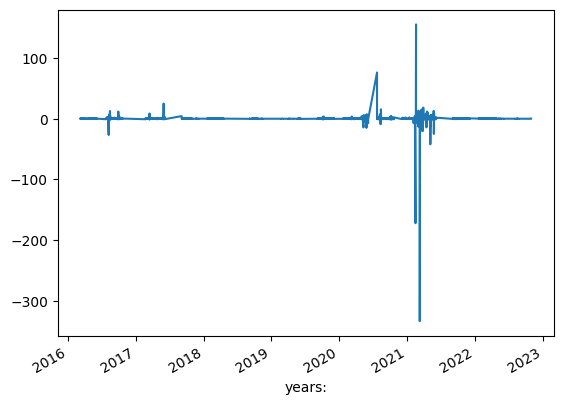

In [86]:
path = "/Users/educontreras/PycharmProjects/Fixed-Income/BoE Yield Curve"
dir_list = os.listdir(path)
for element in dir_list:
    if element != '.DS_Store':
        frames.append(pd.read_excel(f"{path}/{element}",index_col=0, header=3, sheet_name=2))
df = pd.concat(frames)
df.dropna(how = "any", inplace = True)
df = df.sort_index().iloc[:,:20].drop_duplicates().pct_change()
df.iloc[:, 2].plot()

Maybe the Z-Score is not a good metric to see deviations from normality given nowadays situation. We shall use, or a more dynamic one with moving averages or, use directly percentual changes

<AxesSubplot:xlabel='years:'>

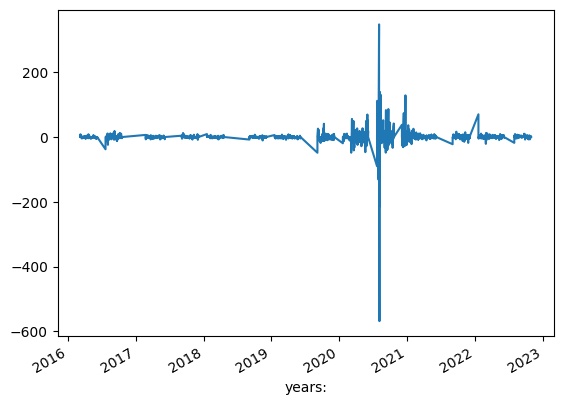

In [76]:
#df = df.sort_index().iloc[:, :20]
#for column in list(df.columns):
#    mu = df.loc[:, column].mean()
#    sd = df.loc[:, column].std()
#    new  = [(element - mu)/sd for element in df.loc[:, column]]
#    df.loc[:, column] = new
#df.loc[:, 2].plot()
######### Instead explaining the Z-Score of interest rates, explain the variations and movements. 
df.iloc[:, 15].plot()

,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,5.5,6.0,6.5,7.0,7.5,8.0,8.5,9.0,9.5,10.0
years:,,,,,,,,,,,,,,,,,,,,
2016-03-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-28,3.736451,3.616632,3.620623,3.669784,3.728189,3.783235,3.829771,3.865542,3.889941,3.903300,3.906525,3.900915,3.888010,3.869472,3.846961,3.822031,3.796057,3.770188,3.745321,3.722091
2022-10-28,3.710825,3.588920,3.591375,3.639573,3.697378,3.752028,3.798256,3.833730,3.857794,3.870755,3.873509,3.867359,3.853856,3.834674,3.811489,3.785867,3.759193,3.732624,3.707057,3.683130
2022-10-31,3.702762,3.578797,3.579861,3.627469,3.685065,3.739620,3.785720,3.820957,3.844649,3.857109,3.859256,3.852422,3.838189,3.818254,3.794316,3.767954,3.740566,3.713313,3.687095,3.662548
